In [ ]:
#1
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import collections
import math
import os
import time

%matplotlib inline

# References to the cpu and the running device (a gpu, if one is available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
print(device)
print(cpu)

cuda:0
cpu


In [ ]:
#2. mount gdrive
# The path references the project folder as if it were under my own directory structure.
# In order to access files (a few hundred megabytes) you will have to copy the YonaVox directory to a location of your choice
# and update the path accordingly.
from google.colab import drive
drive.mount('/root/gdrive')
#first time copy files from original project: !cp -r ./ColabData/YonaVox/ac_audio/*  ./ColabData/YonaVox/ac_audio1/
#in other google account should create shortcut to shared folder: /root/gdrive/.shortcut-targets-by-id/1dBbP3yvAtULEFTCfdX-ZlyuA19YbCpWp
!ln -s /root/gdrive/MyDrive/ColabData /content/
colab_data = "./ColabData/YonaVox/"
!ls /content/ColabData

Mounted at /root/gdrive
YonaVox


In [ ]:
#3. Load the speech data, created in https://colab.research.google.com/drive/1pxtQLo6CsvQYM5vXkL5g909l_QwyU6mK
speech_file = open(colab_data + "hebrew_speech_train", "rb")
tagged_train_spectrograms = np.random.permutation(pickle.load(speech_file))
speech_file.close()

speech_file = open(colab_data + "hebrew_speech_test", "rb")
tagged_test_spectrograms = np.random.permutation(pickle.load(speech_file))
speech_file.close()

print(len(tagged_train_spectrograms))
print(len(tagged_test_spectrograms))

2636
294


<ipython-input-4-6bd6b97ed52d>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  train_spectrograms = normalize_and_permute(torch.tensor(spectrogram_list, dtype=torch.float32))


torch.Size([138, 80])
NOISE


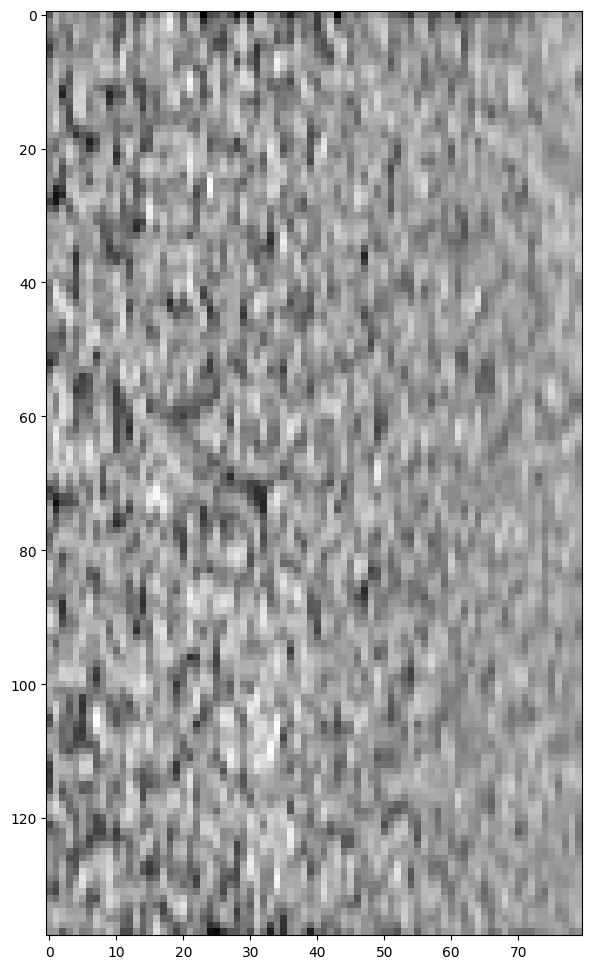

torch.Size([138, 80])
NOISE


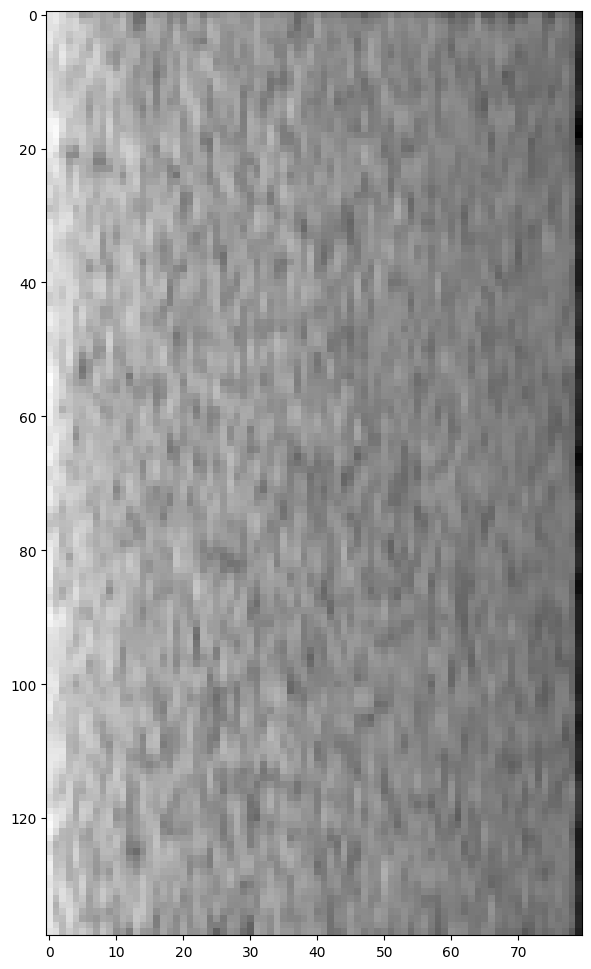

In [ ]:
#4. Normalize the spectrograms and rotate them 90deg clockwise
# The mobile app running these models generates rotates spectrograms faster, and that's where every ms counts.
def normalize_and_permute(spectrograms, epsilon=1e-12):
    # mean = torch.mean(spectrograms, dim=(1, 2), keepdim=True)
    # std = torch.std(spectrograms, dim=(1, 2), keepdim=True) # tensorflow does not use Bessel's correction, Pytorch uses it by default
    # normalized = (spectrograms - mean) / (std + epsilon)
    # permuted = normalized.permute(0, 2, 1)
    permuted = spectrograms.permute(0, 2, 1)
    return torch.unsqueeze(permuted, dim=1)

#Normalize and permute the training set, then plot the first spectrogram in the set
spectrogram_list = [item["spectrogram"] for item in tagged_train_spectrograms]
train_spectrograms = normalize_and_permute(torch.tensor(spectrogram_list, dtype=torch.float32))

print(train_spectrograms[0, 0, :, :].shape)
print(tagged_train_spectrograms[0]["tags"])
plt.figure(figsize=(12,12))
plt.imshow(train_spectrograms[0, 0, :, :], plt.get_cmap("gray"))
plt.show()

#Normalize and permute the test set, then plot the first spectrogram in the set
test_spectrogram_list = [item["spectrogram"] for item in tagged_test_spectrograms]
test_spectrograms = normalize_and_permute(torch.tensor(test_spectrogram_list, dtype=torch.float32))

print(test_spectrograms[0, 0, :, :].shape)
print(tagged_test_spectrograms[0]["tags"])
plt.figure(figsize=(12,12))
plt.imshow(test_spectrograms[0, 0, :, :], cmap=plt.get_cmap("gray"))
plt.show()

In [ ]:
#5. Extract all syllable names from the tracks
track_dir = colab_data + "ac_audio/phrases/"
def get_syllable_list():
    unique_syllables = set()
    for entry in os.listdir(track_dir):
        if entry.endswith(".wav"):
            track_name = entry.split(".")[0]
            syllables = track_name.split("_")
            for s in syllables:
                unique_syllables.add(s)

    return sorted(unique_syllables)

syllables = get_syllable_list()
print(syllables)

# Map all syllables to integer tokens
def map_syllables_to_tokens(syllables):
    syl_to_tokens = collections.OrderedDict()
    syl_to_tokens["END"] = 0
    syl_to_tokens["BEG"] = 1
    syl_to_tokens["BKG"] = 2
    syl_to_tokens["NOISE"] = 3
    for syllable in syllables:
        if syllable not in syl_to_tokens:
            syl_to_tokens[syllable] = len(syl_to_tokens)

    return syl_to_tokens

syl_to_tokens = map_syllables_to_tokens(syllables)
for item in syl_to_tokens.items():
    print(item, end=", ")

['UNK', 'da2', 'gai4', 'ge1', 'hui2', 'qing3']
('END', 0), ('BEG', 1), ('BKG', 2), ('NOISE', 3), ('UNK', 4), ('da2', 5), ('gai4', 6), ('ge1', 7), ('hui2', 8), ('qing3', 9), 

In [ ]:
#6. Extract the tag sequences from the tagged spectrograms, and convert them to sequences of integers
def get_tag_sequences(tagged_spectrograms, pad_to_length):
    tags = [item["tags"].split("_") for item in tagged_spectrograms]
    input_tokens = [[syl_to_tokens["BEG"]] + [syl_to_tokens[tag] for tag in tag_array] for tag_array in tags]
    output_tokens = [[syl_to_tokens[tag] for tag in tag_array] + [syl_to_tokens["END"]] for tag_array in tags]

    padded_input_tokens = torch.zeros((len(tags), pad_to_length), dtype=torch.int64)
    padded_output_tokens = torch.zeros((len(tags), pad_to_length), dtype=torch.int64)

    for idx, tag_array in enumerate(input_tokens):
        padded_input_tokens[idx, :len(tag_array)] = torch.tensor(tag_array, dtype=torch.int64)

    for idx, tag_array in enumerate(output_tokens):
        padded_output_tokens[idx, :len(tag_array)] = torch.tensor(tag_array, dtype=torch.int64)

    return padded_input_tokens, padded_output_tokens

#Convert both training and test set tags into input + output tags, printing a few samples of each set
max_train_tags = np.amax([len(item["tags"].split("_")) for item in tagged_train_spectrograms])
max_test_tags = np.amax([len(item["tags"].split("_")) for item in tagged_test_spectrograms])
pad_to_length = max(max_train_tags, max_test_tags) + 1

train_input_tokens, train_output_tokens = get_tag_sequences(tagged_train_spectrograms, pad_to_length)
test_input_tokens, test_output_tokens = get_tag_sequences(tagged_test_spectrograms, pad_to_length)

print(len(train_input_tokens))
print(train_input_tokens[:3], "\n")
print(train_output_tokens[:3], "\n")

print(len(test_input_tokens))
print(test_input_tokens[:3], "\n")
print(test_output_tokens[:3], "\n")

2636
tensor([[1, 3, 0, 0, 0, 0],
        [1, 3, 0, 0, 0, 0],
        [1, 3, 0, 0, 0, 0]]) 

tensor([[3, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 0]]) 

294
tensor([[1, 3, 0, 0, 0, 0],
        [1, 3, 0, 0, 0, 0],
        [1, 4, 7, 4, 0, 0]]) 

tensor([[3, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 0],
        [4, 7, 4, 0, 0, 0]]) 



In [ ]:
#7. Place all tensors on the GPU, if available
train_spectrograms = train_spectrograms.to(device)
test_spectrograms = test_spectrograms.to(device)
train_input_tokens = train_input_tokens.to(device)
train_output_tokens = train_output_tokens.to(device)
test_input_tokens = test_input_tokens.to(device)
test_output_tokens = test_output_tokens.to(device)

# Network hyper params
freq_features = train_spectrograms[0, 0, :, :].shape[1]
conv_channels = 10
conv_kernel_size = (5, 1)
conv_padding_size = (conv_kernel_size[0] // 2, conv_kernel_size[1] // 2)
rnn_hidden_size = 64
rnn_stacked_layers = 2
embedding_dim = math.ceil(2/3*len(syl_to_tokens))

In [ ]:
#8. The model is an sequence-to-sequence model, made of an encoder and a decoder.
# This is the encoder...
class VoxEncoder(torch.nn.Module):
    def __init__(self):
        #Init constants
        super(VoxEncoder, self).__init__()

        #Layers
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=conv_channels, kernel_size=conv_kernel_size, padding=conv_padding_size)
        self.relu_1 = nn.LeakyReLU()
        self.bn_1 = nn.BatchNorm2d(num_features=conv_channels) # num_features = out_channels in the conv layer

        self.conv_2 = nn.Conv2d(in_channels=conv_channels, out_channels=1, kernel_size=conv_kernel_size, padding=conv_padding_size)
        self.relu_2 = nn.LeakyReLU()
        self.bn_2 = nn.BatchNorm2d(num_features=1)

        self.encoder = nn.GRU(input_size=freq_features, hidden_size=rnn_hidden_size, batch_first=True, bidirectional=True, num_layers=rnn_stacked_layers)

    def forward(self, spectrogram):
        #Conv block 1
        x = spectrogram
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.bn_1(x)

        #Conv block 2
        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.bn_2(x)

        #Encoder
        x = torch.squeeze(x, dim=1)
        encoder_output, enc_h = self.encoder(x)

        #Reshape hidden state to match the dimensions expected by the decoder
        h_layers_twice, h_batch_size, h_output_dim = enc_h.shape
        unidirectional_h = enc_h.reshape((h_layers_twice // 2, h_batch_size, h_output_dim * 2))

        return encoder_output, unidirectional_h

#... And this is the decoder.
class VoxDecoder(torch.nn.Module):
    def __init__(self):
        #Init constants
        super(VoxDecoder, self).__init__()

        #Layers
        self.tag_embed = nn.Embedding(num_embeddings=len(syl_to_tokens), embedding_dim=embedding_dim)
        self.decoder = nn.GRU(input_size=embedding_dim, hidden_size=2*rnn_hidden_size, batch_first=True, bidirectional=False, num_layers=rnn_stacked_layers)

        self.align = nn.Softmax(dim=-1)

        self.linear_1 = nn.Linear(4*rnn_hidden_size, rnn_hidden_size)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(rnn_hidden_size, len(syl_to_tokens))
        self.tanh_2 = nn.Tanh()

    #When using teacher forcing (training phase), tags will be of shape (batch, tag_len)
    #When not using teacher forcing (test phase), tags will be of shape (batch, 1)  (essentially [["BEG"], ["BEG"], ...]
    def forward(self, encoder_output, hidden_state, tags):
        #Decoder
        tag_embeddings = self.tag_embed(tags)
        decoder_output, dec_h = self.decoder(tag_embeddings, hidden_state)

        #Attention block
        attention_scores = torch.bmm(decoder_output, encoder_output.permute(0, 2, 1)) #bmm = batch matrix multiplication
        alignment_vectors = self.align(attention_scores)
        context_vectors = torch.bmm(alignment_vectors, encoder_output)
        concat_contexts = torch.cat([context_vectors, decoder_output], dim=-1)

        #Time-distributed linear (dense) layers
        x = self.linear_1(concat_contexts)
        x = self.tanh_1(x)
        x = self.linear_2(x)
        output = self.tanh_2(x)

        return output, dec_h, alignment_vectors

#Instantiate the model and place on the GPU, if available
encoder = VoxEncoder().to(device)
print(encoder)

decoder = VoxDecoder().to(device)
print(decoder)

# Print the parameter count for the encoder and the decoder
encoder_param_count = sum(param.numel() for param in encoder.parameters() if param.requires_grad)
decoder_param_count = sum(param.numel() for param in decoder.parameters() if param.requires_grad)

print(encoder_param_count)
print(decoder_param_count)
print(encoder_param_count + decoder_param_count)

VoxEncoder(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  (relu_1): LeakyReLU(negative_slope=0.01)
  (bn_1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(10, 1, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  (relu_2): LeakyReLU(negative_slope=0.01)
  (bn_2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): GRU(80, 64, num_layers=2, batch_first=True, bidirectional=True)
)
VoxDecoder(
  (tag_embed): Embedding(10, 7)
  (decoder): GRU(7, 128, num_layers=2, batch_first=True)
  (align): Softmax(dim=-1)
  (linear_1): Linear(in_features=256, out_features=64, bias=True)
  (tanh_1): Tanh()
  (linear_2): Linear(in_features=64, out_features=10, bias=True)
  (tanh_2): Tanh()
)
130693
168848
299541


In [ ]:
# Keeping this cell from the tensorflow version... Can't you plot pytorch models?
# This is how the full model actually looks like.

In [ ]:
#9. Calculate some helper params for the weighted loss and accuracy functions

# Run sample data through the model, to visualize the output and it's dimensions
encoder_output, encoder_state = encoder(test_spectrograms[:1])
decoder_output, decoder_state, align_vec = decoder(encoder_output, encoder_state, test_input_tokens[:1])
#print(decoder_output, decoder_output.shape)

token_frequency = {token:0 for token in syl_to_tokens.values()}
for output_line in train_output_tokens:
    for token in output_line:
        token_frequency[token.item()] += 1

raw_token_weights = np.array(list(token_frequency.values()), dtype=np.float)
inverse_token_weights = np.where(raw_token_weights == 0, 1.0, 1 / (raw_token_weights + 1e-12))
token_weights = torch.tensor(inverse_token_weights / np.sum(inverse_token_weights), dtype=torch.float32).to(device)
loss_scale = torch.mean(torch.tensor(raw_token_weights, dtype=torch.float32)).item()

onehot_tokens = torch.eye(len(token_weights), dtype=torch.float32).to(device)

# Multi-label categorical crossentropy loss on one-hot output vectors, weighted by the frequency of each token in the training set
def weighted_sparse_categorical_crossentropy(labels, logits):
    softmax = F.softmax(logits, dim=-1)
    onehot_labels = torch.stack([torch.stack([onehot_tokens[token.item()] for token in sequence]) for sequence in labels])
    scalar_cce = - onehot_labels * torch.log(softmax + 1e-12)

    reduced_cce = torch.mean(torch.sum(scalar_cce * token_weights, dim=-1, keepdim=True))
    return loss_scale * reduced_cce

weighted_sparse_categorical_crossentropy(test_output_tokens[:2, :1], decoder_output)

# Multi-label categorical accuracy metric on one-hot output vectors, weighted by the frequency of each token in the training set
class WeightedSparseCategoricalAccuracy():
    def __init__(self, token_weights, from_logits=True):
        self.accurate_sum = 0.0
        self.total_sum = 0.0
        self.token_weights = token_weights
        self.from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        predicted_tokens = torch.argmax(y_pred, dim=-1, keepdim=True).squeeze(dim=-1) if self.from_logits else y_pred
        gather_weights = self.token_weights[y_true] #indexing trick from https://stackoverflow.com/questions/53697596/pytorch-equivalent-tf-gather
        accurate_weights = torch.sum(torch.where(y_true == predicted_tokens, gather_weights, torch.tensor(0.0, dtype=gather_weights.dtype).to(device)))
        total_weights = torch.sum(gather_weights)

        self.accurate_sum += accurate_weights.item()
        self.total_sum += total_weights.item()

    def result(self):
        return self.accurate_sum / self.total_sum

    def reset_states(self):
        self.accurate_sum = 0.0
        self.total_sum = 0.0

# Calculate our weighted metric on two example pairs of tokens
wsca = WeightedSparseCategoricalAccuracy(token_weights=token_weights, from_logits=False)

wsca.update_state(
    torch.tensor([[5, 0, 0, 0]], dtype=torch.long).to(device), 
    torch.tensor([[3, 0, 0, 0]], dtype=torch.long).to(device)
)
print(wsca.result())
wsca.reset_states()

wsca.update_state(
    torch.tensor([[5, 0, 0, 0]], dtype=torch.long).to(device), 
    torch.tensor([[5, 1, 1, 1]], dtype=torch.long).to(device)
)
print(wsca.result())
wsca.reset_states()

0.08460995265471817
0.9153900473452818


<ipython-input-9-590b6796d869>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_token_weights = np.array(list(token_frequency.values()), dtype=np.float)


In [ ]:
#10. Training step for a batch of spectrograms + tags, using teacher forcing
def train_batch_tf(encoder, decoder, spectrograms, input_tokens, output_tokens, encoder_optimizer, decoder_optimizer):
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_output, encoder_state = encoder(spectrograms)
    hidden_state = encoder_state

    decoder_iterations = output_tokens.shape[-1]
    predictions = []
    for iter in range(decoder_iterations):
        output_logits, hidden_state, _ = decoder(encoder_output, hidden_state, input_tokens[:, iter:iter+1])
        predictions.append(output_logits)

    predictions = torch.cat(predictions, dim=1)
    cross_entropy_loss = weighted_sparse_categorical_crossentropy(output_tokens, predictions)
    cross_entropy_loss.backward()
    
    decoder_optimizer.step()
    encoder_optimizer.step()

    return cross_entropy_loss.item(), predictions

# Training step for a batch of spectrograms + tags, without teacher forcing
def train_batch(encoder, decoder, spectrograms, output_tokens, encoder_optimizer, decoder_optimizer):
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_output, encoder_state = encoder(spectrograms)
    hidden_state = encoder_state
    input_tokens = torch.full(
        (output_tokens.shape[0], 1), 
        syl_to_tokens["BEG"]
    ).to(device)

    decoder_iterations = output_tokens.shape[-1]
    predictions = []
    for iter in range(decoder_iterations):
        output_logits, hidden_state, _ = decoder(encoder_output, hidden_state, input_tokens)
        _, predicted_tokens = output_logits.topk(1)
        input_tokens = predicted_tokens.squeeze(-1).detach()
        predictions.append(output_logits)

    predictions = torch.cat(predictions, dim=1)
    cross_entropy_loss = weighted_sparse_categorical_crossentropy(output_tokens, predictions)
    cross_entropy_loss.backward()
    
    decoder_optimizer.step()
    encoder_optimizer.step()

    return cross_entropy_loss.item(), predictions

# Evaluation step for a batch of spectrograms + tags, using teacher forcing
def test_batch_tf(encoder, decoder, spectrograms, input_tokens, output_tokens):
    encoder.eval()
    decoder.eval()

    encoder_output, encoder_state = encoder(spectrograms)
    hidden_state = encoder_state

    decoder_iterations = output_tokens.shape[-1]
    predictions = []
    for iter in range(decoder_iterations):
        output_logits, hidden_state, _ = decoder(encoder_output, hidden_state, input_tokens[:, iter:iter+1])
        predictions.append(output_logits)

    predictions = torch.cat(predictions, dim=1)
    cross_entropy_loss = weighted_sparse_categorical_crossentropy(output_tokens, predictions)

    return cross_entropy_loss.item(), predictions

# Evaluation step for a batch of spectrograms + tags, without teacher forcing
def test_batch(encoder, decoder, spectrograms, output_tokens, log=False, force_cpu=False):
    encoder.eval()
    decoder.eval()

    encoder_output, encoder_state = encoder(spectrograms)
    hidden_state = encoder_state
    input_tokens = torch.full(
        (output_tokens.shape[0], 1), 
        syl_to_tokens["BEG"]
    ).to(cpu if force_cpu else device)

    if log:
        print("encoder_output: ", encoder_output, encoder_output.shape)
        print("encoder_state: ", encoder_state, encoder_state.shape)
        print("\n")

    decoder_iterations = output_tokens.shape[-1]
    predictions = []
    for iter in range(decoder_iterations):
        output_logits, hidden_state, _ = decoder(encoder_output, hidden_state, input_tokens)
        if log:
            print("output_logits: ", output_logits, output_logits.shape)
            print("hidden_state: ", hidden_state, hidden_state.shape)
            print("\n")

        _, predicted_tokens = output_logits.topk(1)
        input_tokens = predicted_tokens.squeeze(-1).detach()
        predictions.append(output_logits)

    predictions = torch.cat(predictions, dim=1)
    cross_entropy_loss = weighted_sparse_categorical_crossentropy(output_tokens, predictions)

    return cross_entropy_loss.item(), predictions

# Train the model for the specified number of epochs
def training_loop(encoder, decoder, batch_size, epochs=1, teacher_forcing_ratio=0.5):
    train_examples = len(train_spectrograms)
    test_examples = len(test_spectrograms)
    train_batches = math.ceil(train_examples / batch_size)
    test_batches = math.ceil(test_examples / batch_size)

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
    train_accuracy = WeightedSparseCategoricalAccuracy(token_weights=token_weights)
    test_accuracy = WeightedSparseCategoricalAccuracy(token_weights=token_weights)

    print("Starting training for {} epochs...".format(epochs))
    for epoch in range(epochs):
        epoch_start = time.time()
        for batch_idx in range(train_batches):
            batch_start = batch_idx * batch_size
            batch_end = min(batch_start + batch_size, train_examples)

            spectrogram_batch = train_spectrograms[batch_start:batch_end]
            input_tokens_batch = train_input_tokens[batch_start:batch_end]
            output_tokens_batch = train_output_tokens[batch_start:batch_end]

            if np.random.rand() >= teacher_forcing_ratio:
                batch_loss, logits = train_batch_tf(encoder, decoder, spectrogram_batch, input_tokens_batch, output_tokens_batch, encoder_optimizer, decoder_optimizer)
            else:
                batch_loss, logits = train_batch(encoder, decoder, spectrogram_batch, output_tokens_batch, encoder_optimizer, decoder_optimizer)
            train_accuracy.update_state(output_tokens_batch, logits)

        for batch_idx in range(test_batches):
            batch_start = batch_idx * batch_size
            batch_end = min(batch_start + batch_size, train_examples)

            spectrogram_batch = test_spectrograms[batch_start:batch_end]
            #input_tokens_batch = test_input_tokens[batch_start:batch_end]
            output_tokens_batch = test_output_tokens[batch_start:batch_end]

            batch_loss, logits = test_batch(encoder, decoder, spectrogram_batch, output_tokens_batch)
            test_accuracy.update_state(output_tokens_batch, logits)

        print("\nModel metrics for epoch {}: ".format(epoch + 1))
        print("Test Loss: {}".format(batch_loss))
        print("Weighted Train Accuracy: {}".format(train_accuracy.result()))
        print("Weighted Test Accuracy: {}".format(test_accuracy.result()))
        print ("Training time was {} sec".format(time.time() - epoch_start))

        train_accuracy.reset_states()
        test_accuracy.reset_states()

#Experiment with hyperparams
# conv_channels = 10
# conv_kernel_size = (5, 1)
# rnn_hidden_size = 64
# rnn_stacked_layers = 2

# encoder = VoxEncoder().to(device)
# decoder = VoxDecoder().to(device)
training_loop(
    encoder,
    decoder,
    batch_size=1024, 
    epochs=800
)

# Save the full model, for future use or inference
torch.save(encoder.state_dict(), colab_data + "full_vox_encoder.pt")
torch.save(decoder.state_dict(), colab_data + "full_vox_decoder.pt")

# Save the model as a PyTorch Native C++ module, for use in the Android App
encoder = encoder.to(cpu).eval()
decoder = decoder.to(cpu).eval()

mock_encoder_input = torch.tensor(np.random.rand(*test_spectrograms[:1].shape), dtype=torch.float)
mock_encoder_output = torch.tensor(np.random.rand(*encoder_output.shape), dtype=torch.float)
mock_encoder_state = torch.tensor(np.random.rand(*encoder_state.shape), dtype=torch.float)
mock_decoder_input = torch.tensor(np.random.rand(*test_input_tokens[:1].shape), dtype=torch.long)

traced_encoder = torch.jit.trace(encoder, mock_encoder_input)
traced_decoder = torch.jit.trace(decoder, (mock_encoder_output, mock_encoder_state, mock_decoder_input))

traced_encoder.save(colab_data + "vox_encoder.pt")
traced_decoder.save(colab_data + "vox_decoder.pt")

encoder = encoder.to(device)
decoder = decoder.to(device)

In [ ]:
# Load the trained model from storage, for quick evaluations
# encoder.load_state_dict(torch.load(colab_data + "full_vox_encoder.pt"))
# decoder.load_state_dict(torch.load(colab_data + "full_vox_decoder.pt"))

# encoder = encoder.to(device).eval()
# decoder = decoder.to(device).eval()

In [ ]:
# Sanity check for trained model output, to compare with the model deployed to the mobile app
_, t_out = test_batch(
    encoder, 
    decoder, 
    torch.zeros(1, 1, 138, 80, dtype=test_spectrograms.dtype).to(device), 
    torch.tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=test_input_tokens.dtype).reshape((1, -1)).to(device),
    log=True
)

print(t_out.topk(1))

encoder_output:  tensor([[[ 0.2032,  0.0018, -0.0682,  ...,  0.1416,  0.6037,  0.4808],
         [ 0.2585, -0.8097, -0.7170,  ...,  0.9819,  0.9878, -0.2247],
         [ 0.2472, -0.6320, -0.7592,  ...,  0.9813,  0.9975, -0.7735],
         ...,
         [ 0.8572,  0.9431,  0.9709,  ...,  0.3704,  0.9617, -0.5688],
         [ 0.8148,  0.9334,  0.9703,  ...,  0.3093,  0.9121, -0.2953],
         [ 0.8110,  0.9239,  0.9698,  ...,  0.2065,  0.7724,  0.1343]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward0>) torch.Size([1, 138, 128])
encoder_state:  tensor([[[-0.9716, -0.2954, -0.3430, -0.8391,  0.9995,  0.7539, -0.4577,
          -0.1445,  0.9653, -0.9565,  0.9788, -0.9714,  0.8916, -0.8213,
          -0.5300, -0.7090,  0.3092,  0.9441,  0.9765, -0.9386, -0.9861,
          -0.9995,  0.9589,  0.3641,  0.9201, -0.9849,  0.9305, -0.9287,
           0.9240,  0.9966,  0.9995,  0.9483, -0.9473,  0.9488,  0.4819,
          -0.9737, -0.8393, -0.9954, -0.9696,  0.8701,  0.7906,  0.9990,
        

In [ ]:
# Maps integer tokens back to the syllables they represent
tokens_to_syllables = {token:tag for (tag, token) in syl_to_tokens.items()}

In [ ]:
# Get predictions for training and test data
def training_predictions(start_idx, predictions=5):
    _, test_output = test_batch(encoder, decoder, train_spectrograms[start_idx:start_idx + predictions], train_output_tokens[start_idx:start_idx + predictions])
    test_predictions = torch.argmax(test_output, dim=-1).cpu().numpy()
    return [[tokens_to_syllables[token] for token in prediction] for prediction in test_predictions]

def test_predictions(start_idx, predictions=5):
    _, test_output = test_batch(encoder, decoder, test_spectrograms[start_idx:start_idx + predictions], train_output_tokens[start_idx:start_idx + predictions])
    test_predictions = torch.argmax(test_output, dim=-1).cpu().numpy()
    return [[tokens_to_syllables[token] for token in prediction] for prediction in test_predictions]

In [ ]:
# Compare the ground truth labels with the predicted labels for a sample of the training set
ground_truth = [[tokens_to_syllables[token.item()] for token in prediction] for prediction in train_output_tokens[0:10]]
for tag in ground_truth:
    print(tag)

print("\n\n")    
predictions = training_predictions(0, 10)
for tag in predictions:
    print(tag)

['NOISE', 'END', 'END', 'END', 'END', 'END']
['BKG', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['gai4', 'ge1', 'qing3', 'da2', 'hui2', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['BKG', 'END', 'END', 'END', 'END', 'END']



['NOISE', 'END', 'END', 'END', 'END', 'END']
['BKG', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['gai4', 'gai4', 'qing3', 'qing3', 'qing3', 'qing3']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['BKG', 'END', 'END', 'END', 'END', 'END']


In [ ]:
# Compare the ground truth labels with the predicted labels for a sample of the test set
ground_truth = [[tokens_to_syllables[token.item()] for token in prediction] for prediction in test_output_tokens[0:10]]
for tag in ground_truth:
    print(tag)

print("\n\n")    
predictions = test_predictions(0, 10)
for tag in predictions:
    print(tag)

['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']



['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']
['NOISE', 'END', 'END', 'END', 'END', 'END']


In [ ]:
# Adapted from https://github.com/zszyellow/WER-in-python/blob/master/wer.py
def get_phone_error_rate(truth_line, predicted_line):
    edit_matrix = np.zeros((len(truth_line) + 1, len(predicted_line) + 1), dtype=np.int8)

    for i in range(len(truth_line) + 1):
        edit_matrix[i][0] = i
    for j in range(len(predicted_line) + 1):
        edit_matrix[0][j] = j
    for i in range(1, len(truth_line) + 1):
        for j in range(1, len(predicted_line) + 1):
            if truth_line[i-1] == predicted_line[j-1]:
                edit_matrix[i][j] = edit_matrix[i-1][j-1]
            else:
                substitution_cost = edit_matrix[i-1][j-1] + 1
                insertion_cost = edit_matrix[i][j-1] + 1
                deletion_cost = edit_matrix[i-1][j] + 1
                edit_matrix[i][j] = min(substitution_cost, insertion_cost, deletion_cost)
    return edit_matrix[-1, -1] / len(truth_line)

In [ ]:
# Copied from https://github.com/zszyellow/WER-in-python/blob/master/wer.py
# Explained at https://martin-thoma.com/word-error-rate-calculation/
def weighted_phoneme_error_rate(batch_size=128):
    total_phone_error_rate = 0
    test_batches = math.ceil(len(test_output_tokens) / batch_size)
    for batch_idx in range(test_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(batch_start + batch_size, len(test_output_tokens))

        spectrogram_batch = test_spectrograms[batch_start:batch_end]
        output_tokens_batch = test_output_tokens[batch_start:batch_end]

        _, output = test_batch(encoder, decoder, spectrogram_batch, output_tokens_batch)
        predictions = torch.argmax(output, dim=-1).cpu().numpy()

        for line_idx in range(len(output_tokens_batch)):
            truth_line = output_tokens_batch[line_idx].to(cpu).numpy()
            predicted_line = predictions[line_idx]
            phoneme_error_rate = get_phone_error_rate(truth_line, predicted_line)
            total_phone_error_rate += phoneme_error_rate

            print("truth line: ", truth_line)
            print("predicted_line: ", predicted_line)
            print("PER:", phoneme_error_rate)
            print("\n")

    return total_phone_error_rate / len(test_output_tokens)

In [ ]:
weighted_phoneme_error_rate()

truth line:  [12  4 13 24  2 25  9 13 16 18 30 10  0]
predicted_line:  [12  4 13 24  2 25  9 13 16 18 30 10  0]
PER: 0.0


truth line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
predicted_line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
PER: 0.0


truth line:  [12  4 13 24  2 25  9 13 16 18 30 10  0]
predicted_line:  [12  4 13 24  2 25  9 13 16 18 30 10  0]
PER: 0.0


truth line:  [2 0 0 0 0 0 0 0 0 0 0 0 0]
predicted_line:  [2 0 0 0 0 0 0 0 0 0 0 0 0]
PER: 0.0


truth line:  [26 28 19  8 24 11 23 17  0  0  0  0  0]
predicted_line:  [26 28 19  8 24 11 23 17  0  0  0  0  0]
PER: 0.0


truth line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
predicted_line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
PER: 0.0


truth line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
predicted_line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
PER: 0.0


truth line:  [2 0 0 0 0 0 0 0 0 0 0 0 0]
predicted_line:  [2 0 0 0 0 0 0 0 0 0 0 0 0]
PER: 0.0


truth line:  [3 0 0 0 0 0 0 0 0 0 0 0 0]
predicted_line:  [12  0  0  0  0  0  0  0  0  0  0  0  0]
PER: 0.07692307692307693


truth line:  [12  4 

0.01778568252556691

In [ ]:
# Print the amount of times token sequences of each length appear in the training set
seqs_of_len = {i:0 for i in range(1, 16)}
for seq in train_output_tokens.cpu().numpy():
    non_trivial_tokens = 0;
    for inseq in seq:
        if inseq != 0:
            non_trivial_tokens+=1
        else:
            break;

    if non_trivial_tokens in seqs_of_len:
        seqs_of_len[non_trivial_tokens] += 1
    else:
        seqs_of_len[non_trivial_tokens] = 1

print(seqs_of_len)

{1: 2192, 2: 0, 3: 0, 4: 0, 5: 54, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [ ]:
# Create a confusion matrix based on the test
def create_confusion_matrix(encoder, decoder, batch_size=128):
    confusion_matrix = np.zeros([len(syl_to_tokens), len(syl_to_tokens)])

    test_batches = math.ceil(len(test_output_tokens) / batch_size)
    for batch_idx in range(test_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(batch_start + batch_size, len(test_output_tokens))

        spectrogram_batch = test_spectrograms[batch_start:batch_end]
        output_tokens_batch = test_output_tokens[batch_start:batch_end]

        _, output = test_batch(encoder, decoder, spectrogram_batch, output_tokens_batch)
        predictions = torch.argmax(output, dim=-1).cpu().numpy()

        for line_idx in range(len(output_tokens_batch)):
            truth_line = output_tokens_batch[line_idx]
            predicted_line = predictions[line_idx]

            for token_idx in range(len(truth_line)):
                true_token = truth_line[token_idx]
                predicted_token = predicted_line[token_idx]
                confusion_matrix[true_token, predicted_token] += 1

    true_label_norm_coefficients = np.reshape(np.repeat(np.sum(confusion_matrix, axis=1), len(confusion_matrix)), (len(confusion_matrix), len(confusion_matrix))) + 1e-12
    return confusion_matrix, true_label_norm_coefficients

In [ ]:
# Plot a confusion matrix
def plot_confusion_matrix(confusion_matrix, syllables, figsize=(24,24)):
    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cbar_kws={"aspect":50})

    ax.set_xticklabels(syllables)
    ax.set_yticklabels(syllables)
    ax.set_xlabel("Predicted syllable")
    ax.set_ylabel("True syllable")
    ax.tick_params(
        labelbottom=True, labeltop=True, labelleft=True, labelright=True,
        bottom=True, top=True, left=True, right=True
    )

    plt.show()

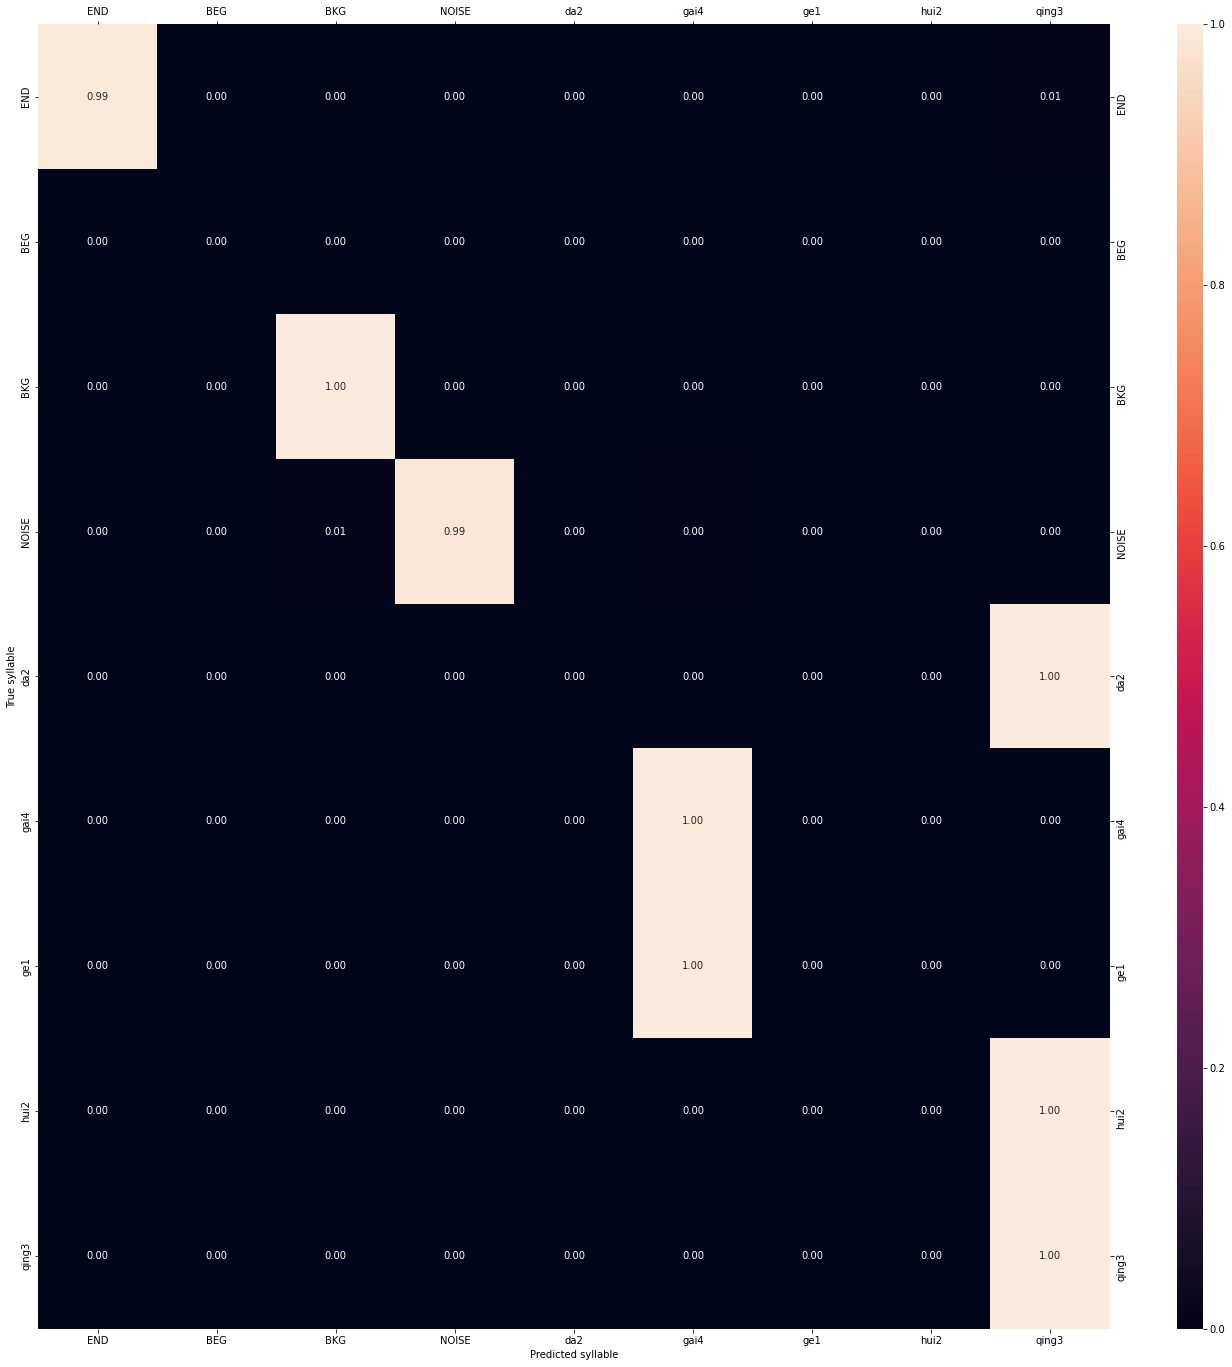

In [ ]:
confusion_matrix, norm_coefficients = create_confusion_matrix(encoder, decoder)
plot_confusion_matrix(confusion_matrix / norm_coefficients, syl_to_tokens.keys())